# Dynamische Generierung einer an das Regelwerk angepassten "openthesaurus.json"-Datei

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
openthesaurus_path = '../data/openthesaurus.txt'
regelwerk_path = '../data/regelbasierte_suche.json'
output_json_path = '../results/openthesaurus_processed.json'

# Regelwerk laden
with open(regelwerk_path, 'r', encoding='utf-8') as f:
    regelwerk = json.load(f)

# Merkmale und ihre positiven/negativen Attribute aus dem Regelwerk
merkmale = regelwerk["merkmale"]
hilfsmerkmale = regelwerk["hilfsmerkmale"]

# Wörterbuch zur Speicherung der Kategorien und ihrer Wörter mit Attributen
output_data = defaultdict(lambda: defaultdict(dict))

Extrahieren von Wörtern und Attributen aus einer Zeile

In [101]:
def parse_line(line):
    # Extrahiere Wörter und Attribute in Klammern
    parts = [part.strip() for part in line.split(';')]
    word_attributes = []

    for part in parts:
        # Suche nach Attributen in Klammern
        match = re.search(r'\((.*?)\)', part)
        if match:
            # Falls Attribute gefunden werden, speichere diese und entferne die Klammern
            attributes = [attr.strip() for attr in match.group(1).split(',')]
            word = re.sub(r'\(.*?\)', '', part).strip()
        else:
            word = part.strip()
            attributes = []

        word_attributes.append((word, attributes))
    
    return word_attributes

Zuordnung von Wörtern in die entsprechenden Merkmalskategorien

In [58]:
# Verarbeitung / Zuordnung von Merkmalen basierend auf positiven, negativen und Hilfsmerkmalen
def process_thesaurus_entry(word, synonyms, attributes, category, positive_attributes):
    # Initialisiere die Struktur für positive, negative Attribute und Synonyme
    word_data = {
        "positive": [],
        "negative": [],
        "synonyms": synonyms
    }
    
    # Prüfe auf positive Zuordnung: Entweder positive Attribute oder Hilfsmerkmale
    # -> Nur wenn pos. Attribut, dann kann auch als neg. Attribut für andere Kategorie zählen
    word_data["positive"].extend([attr for attr in attributes if attr in positive_attributes])
    
    # Prüfen auf Hilfsmerkmale incl. "Pronomen" & Untertypen
    for helper, words in hilfsmerkmale.items():
        if helper in positive_attributes:
            if helper == "Pronomen":
                # Untertypen von "Pronomen" berücksichtigen
                for pronoun_type in hilfsmerkmale["Pronomen"]:
                    if word in hilfsmerkmale.get(pronoun_type, []):
                        word_data["positive"].append(pronoun_type)
            elif word in words:
                word_data["positive"].append(helper)
    
    # Prüfen, ob >= ein positives Merkmal
    has_positive = bool(word_data["positive"]) or not positive_attributes  # Erzwinge für Merkmale ohne positive Attribute
    return word_data if has_positive else None  # Nur bei positiver Zuordnung zurückgeben


# ERSTER DURCHLAUF: Positive Zuordnungen & Merkmale ohne positive Attribute behandeln
with open(openthesaurus_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Ignoriere Kommentare und leere Zeilen
        if line.startswith('#') or not line.strip():
            continue
        
        # Hauptwörter Attribute extrahieren
        word_attributes = parse_line(line)
        
        # Jedes Hauptwort incl. Attribute durchgehen und in Struktur einfügen
        for word, attributes in word_attributes:
            synonyms = [w for w, _ in word_attributes if w != word]
            
            # Verarbeite jedes Merkmal, ordne Wort entsprechend zu, wenn es Attribute erfüllt
            for category, rules in merkmale.items():
                positive_attributes = set(rules.get("positive", []))
                word_data = process_thesaurus_entry(word, synonyms, attributes, category, positive_attributes)
                
                # Für Merkmale ohne positive Attribute (wie "Hochdeutsch" und "Modern")
                if word_data or not positive_attributes:
                    output_data[category][word] = word_data or {"positive": [], "negative": [], "synonyms": synonyms}

# ZWEITER DURCHLAUF: Negative Zuordnungen auf Basis positiver Zuordnungen prüfen
for category, rules in merkmale.items():
    negative_categories = set(rules.get("negative", []))
    
    # Liste zum Speichern der Wörter, die entfernt werden sollen (ohne positve/negative)
    words_to_remove = []
    
    # Über alle bereits positiv zugeordneten Wörter iterieren
    for word, word_data in output_data[category].items():
        # Verwende Set -> Vermeide doppelte negative Merkmale
        negative_set = set()
        
        # Prüfe auf negative Zuordnung: Wenn das Wort einem der negativen Merkmale zugeordnet ist
        for negative in negative_categories:
            # Existiert Wort in einem negativen Merkmal & hat positive Attribute?
            if word in output_data.get(negative, {}) and output_data[negative][word]["positive"]:
                negative_set.add(negative)
                break  # Stoppe, sobald ein passendes negatives Merkmal gefunden wurde

        # Negative Liste aus Set konvertieren und einfügen, falls vorhanden
        if negative_set:
            word_data["negative"] = list(negative_set)
        
        # Berechne den Score basierend auf der Anzahl positiver und negativer Zuordnungen
        word_data["score"] = len(word_data["positive"]) - len(word_data.get("negative", []))
        
        # Markiere das Wort zur Entfernung, wenn es weder positive noch negative Zuordnung hat
        if not word_data["positive"] and not word_data.get("negative", []):
            words_to_remove.append(word)  # Füge das Wort zur Entfernungs-Liste hinzu

    # Entferne markierte Wörter nach Abschluss der Iteration
    for word in words_to_remove:
        del output_data[category][word]

# Ergebnis in JSON speichern
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=4, ensure_ascii=False)

print("JSON-Datei erfolgreich generiert.")


JSON-Datei erfolgreich generiert.


# Sortierung von Sätzen anhand ihres Scorings für verschiedene Merkmale

Einlesen der Datensätze

In [ ]:
processed_json_path = '../results/openthesaurus_processed.json'
dataset_path = '../data/results.array.json'
# regelwerk_path = '../data/regelbasierte_suche.json'
output_path = '../results/genre_based_scoring_results.json'
global_output_path = '../results/global_sentence_scoring_results.json'

# JSON-Dateien laden
with open(processed_json_path, 'r', encoding='utf-8') as f:
    processed_data = json.load(f)

with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

Annotation eines Satzes mit Wort-Scores für eine bessere Nachvollziehbarkeit der Ergebnisse

In [60]:
def annotate_sentence_with_scores(sentence, word_scores):
    annotated_sentence = []
    for word, details in zip(sentence.split(), word_scores):
        # Details für jedes Wort: Score und Attribute
        attr_details = f"{details['score']}|{', '.join(details['attributes'])}" if details["attributes"] else str(details['score'])
        annotated_word = f"{word}({attr_details})"
        annotated_sentence.append(annotated_word)
    return " ".join(annotated_sentence)

Scoring eines Satzes basierend auf einem Merkmal


In [61]:
# Funktion zum Scoring eines Satzes basierend auf einem Merkmal
def score_sentence(sentence, category, category_data):
    score = 0
    word_scores = []
    words = sentence.split()

    for word in words:
        word_score = 0
        word_details = {"word": word, "score": 0, "attributes": []}
        
        # Prüfen, ob das Wort in den Kategorie-Daten vorhanden ist
        word_data = category_data.get(word.lower())
        
        if word_data:
            # Positive und negative Beiträge berechnen
            pos_count = len(word_data["positive"])
            neg_count = len(word_data["negative"])
            
            # Score durch Differenz der positiven und negativen Merkmale
            word_score = pos_count - neg_count
            word_details["score"] = word_score
            word_details["attributes"] = word_data["positive"] + word_data["negative"]
        
        score += word_score
        word_scores.append(word_details)  # Wortdetails sammeln für Annotation

    # Ergebnisstruktur mit normalisiertem Score und Wortdetails
    return {
        "original_score": score,
        "normalized_score": 0,  # Wird später normalisiert
        "annotated_sentence": annotate_sentence_with_scores(sentence, word_scores),
        "words": word_scores
    }

Normalisierung der Scores

In [62]:
def normalize_scores(scores, round_length=2):
    # Min-Max-Normalisierung und Rundung auf 2 NKS
    min_score = min(scores)
    max_score = max(scores)
    return [round((s - min_score) / (max_score - min_score), round_length) if max_score > min_score else 0 for s in scores]


Vollständige Analyse aller Sätze innerhalb eines Genres
- (Top 5 stärkste und 2 schwächste Sätze pro Merkmal)

In [98]:
# Vollständige Analyse aller Sätze innerhalb eines Genres
def full_scoring_analysis():
    results = defaultdict(lambda: defaultdict(list))

    for category, category_data in processed_data.items():
        for theme, sentences in dataset.items():
            category_scores = []
            sentence_scores = []
            
            for sentence in sentences:
                scored_sentence = score_sentence(sentence, category, category_data)
                category_scores.append((scored_sentence["annotated_sentence"], scored_sentence["original_score"], scored_sentence["normalized_score"]))
                sentence_scores.append(scored_sentence["original_score"])
            
            # Normalisierte Scores berechnen
            normalized_scores = normalize_scores(sentence_scores)
            for i, (_, original_score, _) in enumerate(category_scores):
                category_scores[i] = (category_scores[i][0], original_score, normalized_scores[i])
            
            # Sortieren der Sätze nach normalisiertem Score (absteigend)
            category_scores.sort(key=lambda x: x[2], reverse=True)
            
            # 5 stärkste und 2 schwächste Vertreter auswählen
            strongest_representatives = category_scores[:5]
            weakest_representatives = category_scores[-2:]
            
            # Ergebnisse nach Kategorie und Genre speichern
            results[category][theme] = {
                "strongest": strongest_representatives,
                "weakest": weakest_representatives
            }

    # Speichern genre-basierte scores in JSON
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    print("Genre-basierte Scoring-Analyse abgeschlossen und gespeichert.")
    
    # Rückgabe der Ergebnisse für die globale Analyse
    return results

# Aufruf und Speicherung der Ergebnisse
results = full_scoring_analysis()

Genre-basierte Scoring-Analyse abgeschlossen und gespeichert.


Vollständige Analyse aller Sätze über alle Genres hinweg
- (Top 5 stärkste und 2 schwächste Sätze pro Merkmal)

In [100]:
# Vollständige Analyse aller Sätze über alle Genres hinweg
def global_scoring_analysis(results):
    # Dictionary, um Scores für jedes Merkmal über alle Genres hinweg zu speichern
    global_results = defaultdict(list)

    # Durchläuft die bereits berechneten Ergebnisse aus full_scoring_analysis
    for category, themes in results.items():
        for theme_data in themes.values():
            for sentence, original_score, _ in theme_data["strongest"]:
                global_results[category].append((sentence, original_score))
            for sentence, original_score, _ in theme_data["weakest"]:
                global_results[category].append((sentence, original_score))

    # Dictionary zur Speicherung der stärksten und schwächsten Sätze pro Merkmal
    final_global_results = {}

    for category, sentence_scores in global_results.items():
        # Original Scores extrahieren und normalisieren
        original_scores = [score for _, score in sentence_scores]
        normalized_scores = normalize_scores(original_scores)
        
        # Mit normalisierten Scores aktualisieren
        sentence_scores = [(sentence, original_score, normalized_score) for (sentence, original_score), normalized_score in zip(sentence_scores, normalized_scores)]

        # Sortieren nach normalisiertem Score (absteigend)
        sentence_scores.sort(key=lambda x: x[2], reverse=True)  # Sortiert nach normalisiertem Score

        # Top 5 und Bottom 2 für jedes Merkmal auswählen
        strongest_representatives = sentence_scores[:5]
        weakest_representatives = sentence_scores[-2:]

        # Ergebnisse nach Kategorie (Merkmal) speichern
        final_global_results[category] = {
            "strongest": strongest_representatives,
            "weakest": weakest_representatives
        }

    # Globale Ergebnisse in JSON
    with open(global_output_path, 'w', encoding='utf-8') as f:
        json.dump(final_global_results, f, indent=4, ensure_ascii=False)
    print("Globale Scoring-Analyse über alle Genres hinweg abgeschlossen und gespeichert.")

global_scoring_analysis(results)


Globale Scoring-Analyse über alle Genres hinweg abgeschlossen und gespeichert.


Individuelle Analyse für eine bestimmte Kategorie mit eigens gewählten Sätzen

In [102]:
# Individuelle Analyse für eine bestimmte Kategorie mit eigens gewählten Sätzen
def custom_scoring_analysis(sentences, category):
    category_data = processed_data.get(category)
    if not category_data:
        print(f"Die Kategorie '{category}' existiert nicht in den Daten.")
        return []

    # Sätze scoren und sammeln
    scored_sentences = [score_sentence(sentence, category, category_data) for sentence in sentences]
    sentence_scores = [s["original_score"] for s in scored_sentences]
    
    # Normalisierte Scores berechnen
    normalized_scores = normalize_scores(sentence_scores)
    for i, scored_sentence in enumerate(scored_sentences):
        scored_sentence["normalized_score"] = normalized_scores[i]
    
    # Annotierte Sätze und Scores sammeln
    results = [(s["annotated_sentence"], s["original_score"], s["normalized_score"]) for s in scored_sentences]
    results.sort(key=lambda x: x[2], reverse=True)
    return results

# Bsp. individuelle Analyse
example_sentences = [
    "Das Treffen verlief ruhig ohne Überraschungen.",
    "Seine Worte waren so bildhaft und anschaulich, dass sich jeder angesprochen fühlte.",
    "Die Firma konnte einen innovativen Ansatz entwickeln.",
    "Die Debatte war sehr politisch geprägt und voller Fachbegriffe.",
    "Mit einem scherzhaften Lächeln begrüßte er die Gruppe.",
    "Das ist ein typisch obszöner Ausdruck.",
    "Er sprach in einer regionalen Mundart, die nicht jeder verstand.",
    "Ein historische Einfluss war in der gesamten Geschichte spürbar.",
    "Das war ein ganz plauderhafter Kommentar.",
    "In einem satirischen Ton stellte sie die aktuellen Probleme dar."
]
category_to_analyze = "Hochdeutsch"
sorted_sentences = custom_scoring_analysis(example_sentences, category_to_analyze)

# Ausgabe der sortierten Sätze für die individuelle Analyse
print(f"Sortierte Sätze für die Kategorie '{category_to_analyze}':")
for sentence, original_score, normalized_score in sorted_sentences:
    print(f"Original Score: {original_score} | Normalized Score: {normalized_score} | Satz: {sentence}")

Sortierte Sätze für die Kategorie 'Plauderhaft':
Original Score: 4 | Normalized Score: 1.0 | Satz: Er(1|Personalpronomen) sprach(0) in(0) einer(1|ugs.) regionalen(0) Mundart,(0) die(1|ugs.) nicht(0) jeder(1|Indefinitpronomen) verstand.(0)
Original Score: 3 | Normalized Score: 0.75 | Satz: Mit(1|ugs.) einem(0) scherzhaften(0) Lächeln(0) begrüßte(0) er(1|Personalpronomen) die(1|ugs.) Gruppe.(0)
Original Score: 3 | Normalized Score: 0.75 | Satz: Ein(0) historische(0) Einfluss(0) war(0) in(0) der(3|Pronomen, Demonstrativpronomen, Relativpronomen) gesamten(0) Geschichte(0) spürbar.(0)
Original Score: 2 | Normalized Score: 0.5 | Satz: Seine(0) Worte(0) waren(0) so(0) bildhaft(0) und(0) anschaulich,(0) dass(0) sich(1|Reflexivpronomen) jeder(1|Indefinitpronomen) angesprochen(0) fühlte.(0)
Original Score: 2 | Normalized Score: 0.5 | Satz: In(0) einem(0) satirischen(0) Ton(0) stellte(0) sie(1|Personalpronomen) die(1|ugs.) aktuellen(0) Probleme(0) dar.(0)
Original Score: 1 | Normalized Score: 0.2

Visualisierung der individuellen Analyse

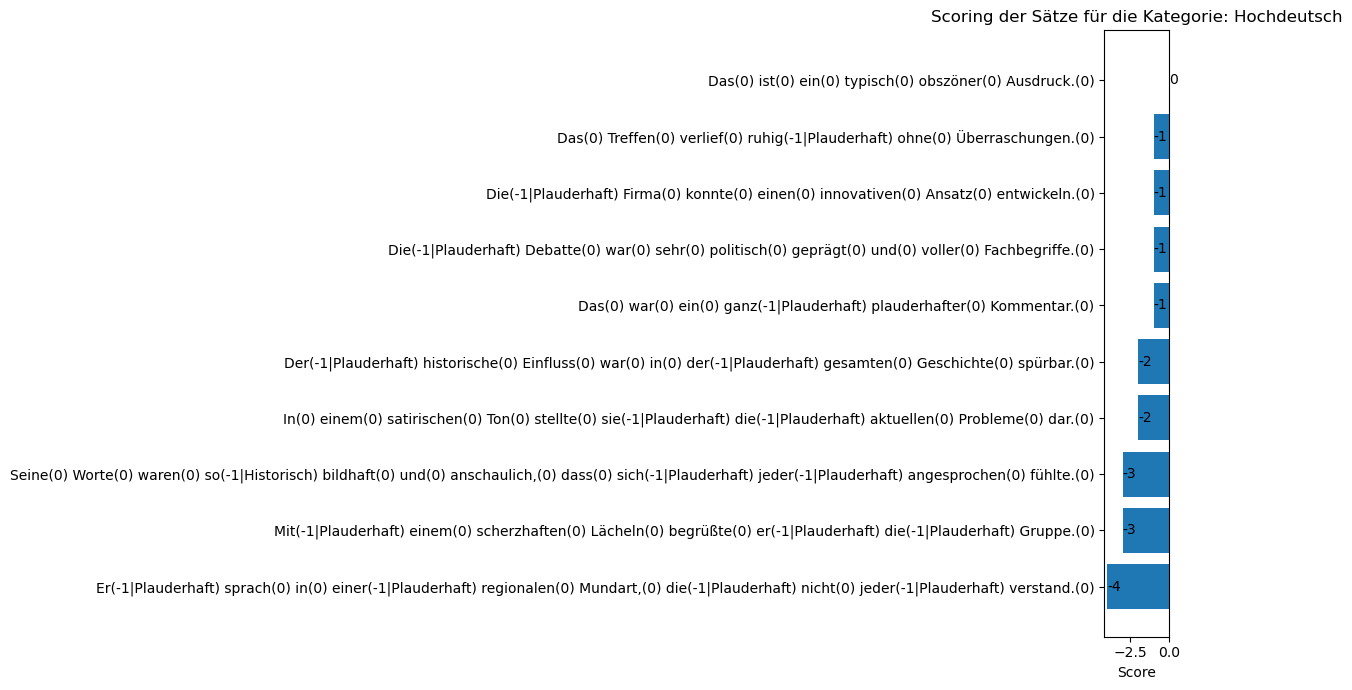

In [67]:
def visualize_custom_scoring(sorted_sentences, category):
    # Extrahiere Sätze und ihre Scores
    sentences = [s[0] for s in sorted_sentences]
    scores = [s[1] for s in sorted_sentences]

    # Plot erstellen
    plt.figure(figsize=(12, min(2 + 0.5 * len(sentences), 10)))  # Dynamische Höhe je nach Satzanzahl
    bars = plt.barh(sentences, scores, align='center')
    plt.xlabel('Score')
    plt.title(f'Scoring der Sätze für die Kategorie: {category}')
    
    # Sortierung Stärkster bis schwächster Vertreter
    plt.gca().invert_yaxis()

    # Score-Werte auf Balken schreiben
    for bar, score in zip(bars, scores):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score}', va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

# Analysiere / sortiere Bsp.-Sätze
sorted_sentences = custom_scoring_analysis(example_sentences, category_to_analyze)

# Visualisierung aufrufen
visualize_custom_scoring(sorted_sentences, category_to_analyze)


# Vektorisierung des Wortschatzes der Bücher mittels TF-IDF

Lade Bücherliste

In [ ]:
dataset_path = '../data/results.array.json'

with open(dataset_path, 'r', encoding='utf-8') as f:
    genres_data = json.load(f)

Datenvorbereitung

In [ ]:
# Sätze pro Genre zu einem Text zusammenfassen
genres_texts = {genre: " ".join(sentences) for genre, sentences in genres_data.items()}

# Genre-Namen und Textinhalte extrahieren
genre_names = list(genres_texts.keys())
genre_texts = list(genres_texts.values())

Vektorisierung

In [ ]:
# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(genre_texts)

# Cosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(tfidf_matrix)

# Ergebnis als DataFrame
cosine_df = pd.DataFrame(cosine_similarities, index=genre_names, columns=genre_names)
print("Cosinus-Ähnlichkeit zwischen den Genres:")
display(cosine_df)

Cosinus-Ähnlichkeit zwischen den Genres:


,nightmarish,positive,real-time,timely,uplifting,witty,whimsical,visionary,versatile,varied,...,authentic,assertive,analytical,amusing,agenda-driven,adventurous,advanced,addictive,action-packed,academic
nightmarish,1.000000,0.628234,0.688311,0.621456,0.535734,0.175694,0.568591,0.623105,0.698270,0.708903,...,0.717157,0.620010,0.579543,0.601785,0.610954,0.615434,0.641474,0.614623,0.652962,0.623401
positive,0.628234,1.000000,0.791062,0.628937,0.766768,0.204623,0.534849,0.732415,0.837628,0.797659,...,0.777609,0.814054,0.613656,0.588462,0.703692,0.594522,0.718401,0.826931,0.647258,0.677598
real-time,0.688311,0.791062,1.000000,0.903930,0.647125,0.195914,0.560058,0.860597,0.919134,0.893045,...,0.863919,0.857537,0.793529,0.680482,0.888973,0.713634,0.873574,0.761832,0.770411,0.851862
timely,0.621456,0.628937,0.903930,1.000000,0.528018,0.152086,0.507079,0.825523,0.811101,0.796035,...,0.775762,0.750348,0.775767,0.629484,0.851107,0.660763,0.841785,0.635236,0.711793,0.829553
uplifting,0.535734,0.766768,0.647125,0.528018,1.000000,0.255204,0.440663,0.608670,0.643573,0.626809,...,0.647834,0.647804,0.498422,0.486576,0.596529,0.545285,0.572287,0.804204,0.530251,0.539690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adventurous,0.615434,0.594522,0.713634,0.660763,0.545285,0.172147,0.574022,0.643600,0.732627,0.753391,...,0.753100,0.622616,0.616910,0.611746,0.655640,1.000000,0.678055,0.655267,0.685449,0.665468
advanced,0.641474,0.718401,0.873574,0.841785,0.572287,0.141409,0.532887,0.862057,0.881906,0.853588,...,0.815613,0.835519,0.824792,0.605462,0.829690,0.678055,1.000000,0.675540,0.741445,0.967399
addictive,0.614623,0.826931,0.761832,0.635236,0.804204,0.241178,0.531903,0.692597,0.776708,0.754555,...,0.758457,0.713225,0.596365,0.606194,0.689491,0.655267,0.675540,1.000000,0.628200,0.647742
action-packed,0.652962,0.647258,0.770411,0.711793,0.530251,0.156250,0.567624,0.687203,0.776815,0.788018,...,0.796770,0.683543,0.656290,0.620288,0.702347,0.685449,0.741445,0.628200,1.000000,0.718357


Visualisierung der Top 10 cosinus-ähnlichsten Genre-Paare

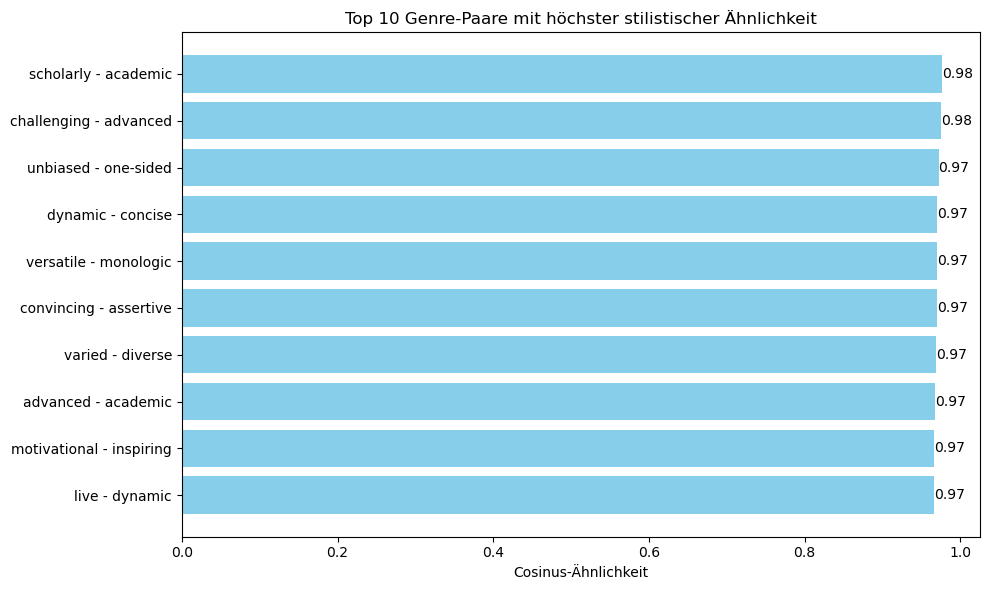

In [ ]:
# Extrahiere oberen Dreieckswerte der Cosinus-Ähnlichkeitsmatrix ohne Diagonaleinträge
similarities = []
for i in range(len(genre_names)):
    for j in range(i + 1, len(genre_names)):
        similarities.append((cosine_df.iloc[i, j], genre_names[i], genre_names[j]))

# Sortiere Ähnlichkeiten absteigend & wähle Top 10 Paare aus
top_10_similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:10]

# Paare und ihre Ähnlichkeiten extrahieren
top_10_scores = [pair[0] for pair in top_10_similarities]
top_10_pairs = [f"{pair[1]} - {pair[2]}" for pair in top_10_similarities]

# Visualisierung der Top 10 Paare mit der höchsten Ähnlichkeit
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_pairs, top_10_scores, color='skyblue')
plt.xlabel('Cosinus-Ähnlichkeit')
plt.title('Top 10 Genre-Paare mit höchster stilistischer Ähnlichkeit')
plt.gca().invert_yaxis()

# Score-Werte auf die Balken schreiben
for bar, score in zip(bars, top_10_scores):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{score:.2f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()
